### E-commerce Customer Segmentation (RFM + K-Means)

In [1]:
#Import all required dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from datetime import datetime

#### Step 1: Data Cleaning & Preprocessing
##### Load and Clean the Data

In [2]:
#Import dataset from uicml
from ucimlrepo import fetch_ucirepo

#Fecth dataset
online_retail = fetch_ucirepo(id=352)

In [4]:
# metadata 
print(online_retail.metadata)

{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Oct 21 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based customer segmenta

In [5]:
# variable information 
print(online_retail.variables)

          name     role         type demographic  \
0    InvoiceNo       ID  Categorical        None   
1    StockCode       ID  Categorical        None   
2  Description  Feature  Categorical        None   
3     Quantity  Feature      Integer        None   
4  InvoiceDate  Feature         Date        None   
5    UnitPrice  Feature   Continuous        None   
6   CustomerID  Feature  Categorical        None   
7      Country  Feature  Categorical        None   

                                         description     units missing_values  
0  a 6-digit integral number uniquely assigned to...      None             no  
1  a 5-digit integral number uniquely assigned to...      None             no  
2                                       product name      None             no  
3  the quantities of each product (item) per tran...      None             no  
4  the day and time when each transaction was gen...      None             no  
5                             product price per uni

In [6]:
online_retail

{'data': {'ids':        InvoiceNo StockCode
  0         536365    85123A
  1         536365     71053
  2         536365    84406B
  3         536365    84029G
  4         536365    84029E
  ...          ...       ...
  541904    581587     22613
  541905    581587     22899
  541906    581587     23254
  541907    581587     23255
  541908    581587     22138
  
  [541909 rows x 2 columns],
  'features':                                 Description  Quantity      InvoiceDate  \
  0        WHITE HANGING HEART T-LIGHT HOLDER         6   12/1/2010 8:26   
  1                       WHITE METAL LANTERN         6   12/1/2010 8:26   
  2            CREAM CUPID HEARTS COAT HANGER         8   12/1/2010 8:26   
  3       KNITTED UNION FLAG HOT WATER BOTTLE         6   12/1/2010 8:26   
  4            RED WOOLLY HOTTIE WHITE HEART.         6   12/1/2010 8:26   
  ...                                     ...       ...              ...   
  541904          PACK OF 20 SPACEBOY NAPKINS        12  12/9

In [12]:
df = online_retail.data.original
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [16]:
df.value_counts()

InvoiceNo  StockCode  Description                          Quantity  InvoiceDate       UnitPrice  CustomerID  Country       
555524     22698      PINK REGENCY TEACUP AND SAUCER        1        6/5/2011 11:37    2.95       16923.0     United Kingdom    20
           22697      GREEN REGENCY TEACUP AND SAUCER       1        6/5/2011 11:37    2.95       16923.0     United Kingdom    12
572861     22775      PURPLE DRAWERKNOB ACRYLIC EDWARDIAN   12       10/26/2011 12:46  1.25       14102.0     United Kingdom     8
572344     M          Manual                                48       10/24/2011 10:43  1.50       14607.0     United Kingdom     6
578289     23395      BELLE JARDINIERE CUSHION COVER        1        11/23/2011 14:07  3.75       17841.0     United Kingdom     6
                                                                                                                                ..
553915     21174      POTTERING IN THE SHED METAL SIGN      12       5/19/2011 19:51   2.

In [17]:
#Data Cleaning
#Drop missing customer IDs [essential for segmentation]
df = df.dropna(subset=['CustomerID'])

# Remove cancelled/refunded transactions (negative quantities)
df = df[df['Quantity']>0]

# Create a "Total Price" column
df['Total_price'] = df['Quantity']*df['UnitPrice']

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Display cleaned dataset
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


#### Exploratory Data Analysis (EDA)
##### Step 2: Create RFM Features

In [19]:
#Define snapshot last transaction date
snapshot_date = df['InvoiceDate'].max()

# Calculate Recency, Frequency, and Monetary values per customer
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x : (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Total_price': 'sum'
})

# Rename columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'}, inplace=True)

# Display RFM dataset
rfm.head()

,Recency,Frequency,Total_price
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,7,4310.00
12348.0,74,4,1797.24
12349.0,18,1,1757.55
12350.0,309,1,334.40


#### Clustering & Segmentation 
##### Step 3: Apply K-Means Clustering

In [20]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
rfm_scaled = scalar.fit_transform(rfm)

#Covert to panda frame
rfm_scaled = pd.DataFrame(rfm_scaled, columns= ['Recency','Frequency','Monetary'])

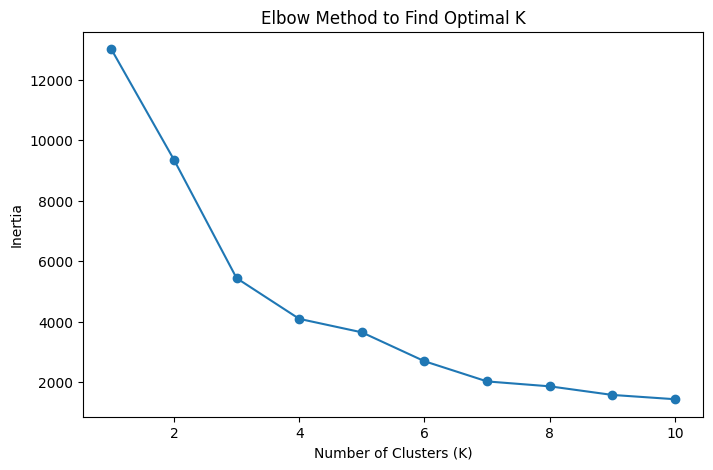

In [21]:
#Find Optimal K (Elbow Method)
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Find Optimal K')
plt.show()


In [22]:
# Fit K-Means with optimal K (let's assume 4)
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Display clustered dataset
rfm.head()


,Recency,Frequency,Total_price,Cluster
CustomerID,,,,
12346.0,325,1,77183.60,1
12347.0,1,7,4310.00,0
12348.0,74,4,1797.24,0
12349.0,18,1,1757.55,0
12350.0,309,1,334.40,1


In [23]:
rfm.groupby('Cluster').mean()

,Recency,Frequency,Total_price
Cluster,,,
0,40.445682,4.671928,1855.367927
1,246.106285,1.582255,631.424206
2,5.038462,66.500000,85904.351538


In [45]:
rfm_scaled['Cluster'] = rfm['Cluster'].values #assign cluster column

In [46]:
print(rfm_scaled['Cluster'].isnull().sum())  # Should be 0
print(rfm_scaled['Cluster'].value_counts())  # Should show counts for different clusters

0
Cluster
0    3231
1    1082
2      26
Name: count, dtype: int64


In [47]:
print(rfm_scaled.isnull().sum())  # Check for missing values

Recency      0
Frequency    0
Monetary     0
Cluster      0
dtype: int64


#### Visualization & Business Insights
##### Draw a plot using Seaborn & Matplotlib

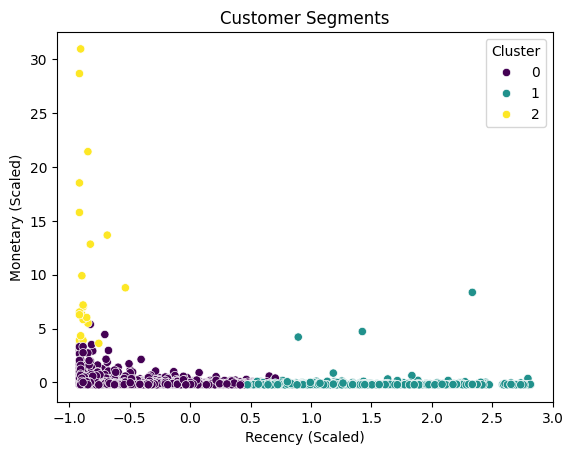

In [48]:
sns.scatterplot(x=rfm_scaled['Recency'], y=rfm_scaled['Monetary'], hue=rfm_scaled['Cluster'], palette='viridis')
plt.xlabel("Recency (Scaled)")
plt.ylabel("Monetary (Scaled)")
plt.title("Customer Segments")
plt.legend(title="Cluster")
plt.show()

# 📊 Customer Segments Analysis

## 🧐 Interpretation of the Scatter Plot

### **Cluster 0 (Dark Purple)**
- Customers with **low recency** (recent buyers).
- Mostly low to moderate monetary values.
- **Largest cluster** → Likely **regular buyers with moderate spending**.

### **Cluster 1 (Teal/Blue-Green)**
- Customers with **high recency** (haven't purchased in a while).
- Lower monetary values.
- Represents **churned or inactive customers**.

### **Cluster 2 (Yellow)**
- Customers with **low recency (recent buyers) but high monetary values**.
- Likely **high-value or VIP customers**.

/var/folders/9m/xmb6cfqs55d_cp4t3s4m_9180000gn/T/ipykernel_67150/3303577002.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=rfm["Cluster"], palette="viridis")


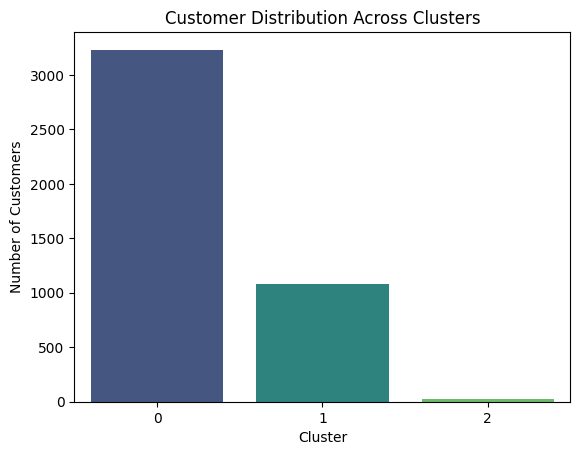

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count plot for clusters
sns.countplot(x=rfm["Cluster"], palette="viridis")
plt.title("Customer Distribution Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.show()


/var/folders/9m/xmb6cfqs55d_cp4t3s4m_9180000gn/T/ipykernel_67150/211361888.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=rfm_scaled["Cluster"], y=rfm_scaled["Monetary"], palette="viridis")


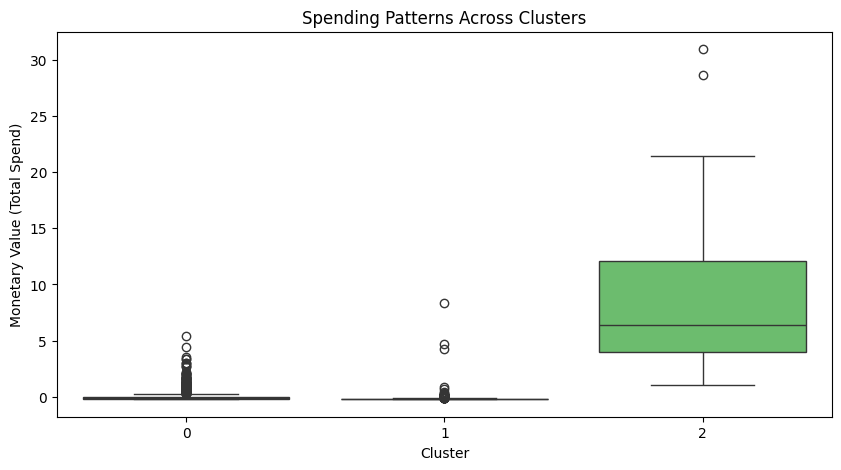

In [61]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=rfm_scaled["Cluster"], y=rfm_scaled["Monetary"], palette="viridis")
plt.title("Spending Patterns Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Monetary Value (Total Spend)")
plt.show()


### ***Understanding the Boxplot (Spending Patterns Across Clusters)***

- The X-axis represents different clusters (0, 1, and 2).
- The Y-axis represents the Monetary Value (Total Spend) by customers.
- The boxplot shows how spending varies across different clusters.
### **Insights from the Boxplot**:

#### 1. Cluster 0 & 1:
- These clusters have low total spend, indicating low-value customers.
- There are many outliers, suggesting some customers in these clusters spend more than the typical range.
#### 2. Cluster 2:
- This cluster has a significantly higher total spend.
- The median spend is much higher than Clusters 0 and 1.
- There are a few extreme high-value outliers, meaning some customers spend exceptionally more.
### Conclusion:
- Cluster 2 represents high-value customers who contribute the most to revenue.
- Clusters 0 and 1 likely consist of low-value or occasional buyers.

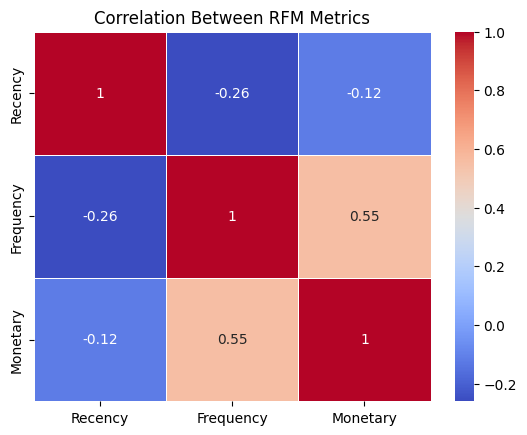

In [62]:
sns.heatmap(rfm_scaled[['Recency', 'Frequency', 'Monetary']].corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Between RFM Metrics")
plt.show()

### **Understanding the Heatmap (Correlation Between RFM Metrics)**
- The heatmap displays correlations between Recency, Frequency, and Monetary Value.
- Values range from -1 to 1:
    - 1 (red) → Strong positive correlation.
    - 1 (blue) → Strong negative correlation.
    - 0 (neutral) → No correlation.
#### **Insights from the Heatmap:**
1. Frequency & Monetary Value (0.55 correlation):
- Moderate positive correlation.
- Customers who purchase more frequently tend to spend more.
2. Recency & Frequency (-0.26 correlation):
- Slight negative correlation.
- Customers who purchase frequently tend to have lower recency values (i.e., they buy more recently).
3. Recency & Monetary (-0.12 correlation):
- Weak negative correlation.
- Customers who haven't purchased recently don't necessarily spend less.
#### **Conclusion:**
- Focusing on frequent buyers can be a good strategy since they also tend to spend more.
- Recency has a weaker impact on monetary value, so not all recent customers are high spenders.

In [64]:
rfm

,Recency,Frequency,Total_price,Cluster
CustomerID,,,,
12346.0,325,1,77183.60,1
12347.0,1,7,4310.00,0
12348.0,74,4,1797.24,0
12349.0,18,1,1757.55,0
12350.0,309,1,334.40,1
...,...,...,...,...
18280.0,277,1,180.60,1
18281.0,180,1,80.82,1
18282.0,7,2,178.05,0


In [69]:
#Save dataframe to csv to use it for visualizations
file_path = "/Users/prudhvileo/Downloads/rfm_scaled.csv"
rfm_scaled.to_csv(file_path, index=False)

file_path

'/Users/prudhvileo/Downloads/rfm_scaled.csv'